In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# !pip install langchain
#! pip install langchain_openai
# ! pip install langchain_huggingface
#! pip install langgraph

In [30]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Optional, Annotated
from pydantic import BaseModel, Field, EmailStr
import operator

# Model Initialisation

In [66]:
open_ai_key = 'your_api_key'

model = ChatOpenAI(model='gpt-4o-mini', api_key = open_ai_key)

# Pydantic Output Parser

In [33]:
class EvaluationSchema(BaseModel):

    feedback: str = Field(description='Detailed feedback of the essay.')
    score: float = Field(description='Scoring the essay', ge=0, le=10)

In [34]:
structured_model = model.with_structured_output(EvaluationSchema)

In [63]:
essay = """ Global warming is one of the most pressing challenges facing humanity today. It refers to the long-term increase in Earth's average surface temperature due to the buildup of greenhouse gases in the atmosphere. These gases, such as carbon dioxide, methane, and nitrous oxide, are largely the result of human activities like the burning of fossil fuels, deforestation, and industrial emissions. As these gases trap heat from the Sun, they create a "greenhouse effect," causing the planet to warm at an unprecedented rate. The consequences of global warming are far-reaching and affect every part of the world. Melting glaciers and rising sea levels threaten coastal communities, while changing weather patterns lead to more frequent and intense droughts, floods, and storms. Agriculture suffers, biodiversity declines, and public health is increasingly at risk. Despite international agreements like the Paris Accord, progress has been slow, and urgent action is needed. Switching to renewable energy, conserving forests, promoting sustainable lifestyles, and investing in climate-resilient infrastructure are crucial steps. The fight against global warming requires collective global effort, political will, and a shift in how we interact with our environment. The choices we make today will determine the kind of planet we leave for future generations.


"""

# Prompt to be sent to LLM

In [ ]:
prompt= f'Evaluate the essay from 0 to 10 and provide a feedback on the essay: {essay}'

In [ ]:
result = structured_model.invoke(prompt)

In [ ]:
print(result)
print(result.feedback)
print(result.score)

# Creating TypedDict State 

In [44]:
class UPSCState(TypedDict):

    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str

    individual_scores: Annotated[list[float], operator.add]
    avg_score: float = Field(description="Average score of all the individual score provided.")

#  operator.add : reducer function. will merge the individual feedback scores into individual score list


In [36]:
def evaluate_analysis(state: UPSCState):

    prompt = f' Evaluate the essay based on depth of analysis and share feedback message and score b/w 0-10 in decimal. Essay: {state["essay"]}'

    result = structured_model.invoke(prompt)

    # partial state return 
    return {"analysis_feedback": result.feedback, "individual_scores": [result.score]}
    

In [38]:
def evaluate_language(state: UPSCState): 
    
    prompt = f' Evaluate the essay based on laguage quality and share feedback message and score b/w 0-10 in decimal. Essay: {state["essay"]}'

    result = structured_model.invoke(prompt)

    # partial state return 
    return {"language_feedback": result.feedback, "individual_scores": [result.score]}

In [39]:
def evaluate_clarity(state: UPSCState):
    prompt = f' Evaluate the essay based on clarity of thought and share feedback message and score b/w 0-10 in decimal. Essay: {state["essay"]}'

    result = structured_model.invoke(prompt)

    # partial state return 
    return {"clarity_feedback": result.feedback, "individual_scores": [result.score]}

In [47]:
def evaluate_final(state: UPSCState):

    # summary feedback

    prompt = f'Based on the following feedbacks, summarize the feedback. \n analysis_feedback: {state["analysis_feedback"]}, language_feedback: {state["language_feedback"]}, clarity_feedback: {state["clarity_feedback"]}'

    feedback_summary = model.invoke(prompt).content

    # avg feedback

    avg_score = sum(state["individual_scores"])/len(state["individual_scores"])

    return {"overall_feedback": feedback_summary,  "avg_score": avg_score}

# Creating Parallel Workflow

In [48]:
graph = StateGraph(UPSCState)

# nodes
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_clarity', evaluate_clarity)
graph.add_node('evaluate_final', evaluate_final)


# edges

graph.add_edge(START, "evaluate_analysis")
graph.add_edge(START, "evaluate_language")
graph.add_edge(START, "evaluate_clarity")

graph.add_edge("evaluate_analysis", "evaluate_final")
graph.add_edge("evaluate_language", "evaluate_final")
graph.add_edge("evaluate_clarity", "evaluate_final")

graph.add_edge("evaluate_final", END)

workflow = graph.compile()

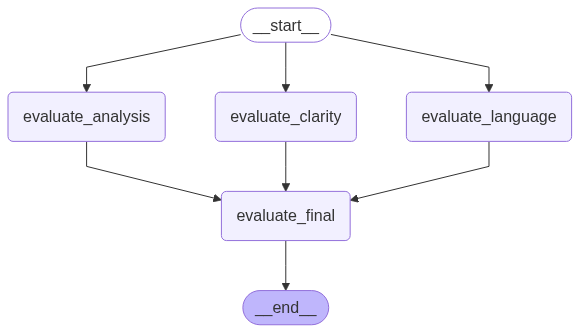

In [50]:
workflow

# Model Invokation

In [64]:
initial_state = {
    "essay": essay
}

output = workflow.invoke(initial_state)

# Final Output

In [65]:
print(f"analysis_feedback : {output['analysis_feedback']}")

print(f"language_feedback : {output['language_feedback']}")

print(f"clarity_feedback: {output['clarity_feedback']}")

print(f"individual_scores: {output['individual_scores']}")

print(f"overall_feedback: {output['overall_feedback']}")

print(f"avg_score: {output['avg_score']}")

analysis_feedback : The essay presents a clear overview of global warming, its causes, and its wide-ranging effects. It identifies greenhouse gases and human contributions to warming, emphasizing the urgency of the crisis. However, the analysis could benefit from greater depth in several areas. For instance, while it mentions international efforts like the Paris Accord, it does not discuss specific challenges or failures associated with these initiatives. Additionally, the essay touches on solutions but lacks detailed examples of how renewable energy can be implemented or how sustainable lifestyles might be promoted. More comprehensive analysis of the social, economic, and political factors influencing climate change solutions would enhance the argument's depth. Overall, the essay is informative and well-structured but could dive deeper into specific issues and solutions for a more nuanced discussion.
language_feedback : The essay presents a coherent and relevant discussion on global w